## Detalle sobre este notebook (fv_periodo):
* Este notebook utiliza los programas presidenciales del cualquier período de 5 años, los compara según su correlación por temas etiquetados, por país.
* Selecciona un Feature Vector acotado
* Construye una red de similaridad.
* Luego identifica comunidades.
* Luego estima métricas de centralidad
* al final tiene conclusiones sobre el período #15 (1990-1994)

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain


#### Cargar df_5_extended

In [2]:
df_5_extended = pd.read_excel('df_5_extended.xlsx')
df_5_extended.head()

countryname  ventana_5    per101   per102    per103    per104    per105  \
0     Albania         15  3.113815  0.00000  1.559835  2.046771  0.331285   
1     Albania         16  3.716797  0.00000  0.051879  3.519091  0.015910   
2     Albania         17  2.392570  0.00000  0.000000  2.757403  0.026619   
3   Argentina         14  0.000000  0.00000  4.619213  0.448618  0.828036   
4   Argentina         16  0.254185  0.02014  0.725611  1.406834  0.100835   

     per106    per107    per108  ...  per606_1  per606_2  per607_1  per607_2  \
0  1.674371  4.632186  5.169904  ...  0.000000       0.0  0.000000       0.0   
1  0.579077  4.971347  1.981720  ...  0.000000       0.0  0.000000       0.0   
2  0.023948  3.523162  1.452779  ...  0.000000       0.0  0.000000       0.0   
3  0.338070  2.955090  0.000000  ...  7.595332       0.0  0.326532       0.0   
4  1.720736  5.478894  3.932102  ...  4.494125       0.0  0.443809       0.0   

   per607_3  per608_1  per608_2  per608_3  per703_1  per703_2  
0  0.000000       0.0       0.0       0.0  0.000000       0.0  
1  0.000000       0.0       0.0       0.0  0.000000       0.0  
2  0.000000       0.0       0.0       0.0  0.000000       0.0  
3  0.000000       0.0       0.0       0.0  2.495280       0.0  
4  0.809128       0.0       0.0       0.0  2.573783       0.0  

[5 rows x 144 columns]

In [3]:
df_5_extended.shape

(1407, 144)

In [4]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


Dominio      Nombre_Dominio Variable_per  \
0  Domain_1  External Relations       per101   
1  Domain_1  External Relations       per102   
2  Domain_1  External Relations       per103   
3  Domain_1  External Relations       per104   
4  Domain_1  External Relations       per105   

                           Detalle_Dominio  
0  Foreign Special Relationships: Positive  
1  Foreign Special Relationships: Negative  
2                         Anti-Imperialism  
3                       Military: Positive  
4                       Military: Negative

In [5]:
all_per_variables = [col for col in df_5_extended.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


In [6]:
len(all_per_variables)

142

#### 1. TRABAJO CON ASPECTOS PARTICULARES
   * Crearemos una lista de nombres de 'aspectos' junto con una lista de nombres de variables que lo explican
   * Consolidaremos 'df_5_extended' para que incluya solamente las volumnas de interés para cada aspecto.


#### 1.1 Lista de aspectos y variables de interés
* Aspecto específicos:
       
*          * Inclusión y Minorías
*          * Orden y Corrupción
*          * Medio Ambiente y Sostenibilidad
*          * Pueblos Originarios
*          * Derechos Humanos
*          * Inmigración
*          * Moral Tradicional 


#### Correlación de Pearson

**Qué es**: La correlación de Pearson mide la relación lineal entre dos conjuntos de datos. En este caso, mediría cómo se correlacionan los porcentajes de las etiquetas temáticas entre dos programas de gobierno.

**Aplicación**: Para cada par de programas de gobierno (por ejemplo, "Chile_1990" y "Alemania_1980"), calcula la correlación de Pearson usando sus respectivos vectores de porcentajes de las 56 etiquetas temáticas.

Si el vector de "Chile_1990" es `[x1,x2,...,x56]` y el de "Alemania_1980" es `[y1,y2,...,y56]`, entonces la correlación de Pearson se calcula como:

$$
r = \frac{\sum_{i=1}^{56} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{56} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{56} (y_i - \bar{y})^2}}
$$

Donde $\bar{x}$ y $\bar{y}$ son las medias de los vectores de porcentajes.

#### Interpretación de la Correlación:
El valor de $r$ está en el rango $[-1,1]$, donde:

- $r = 1$ indica una correlación positiva perfecta (discursos muy similares en la distribución temática).
- $r = -1$ indica una correlación negativa perfecta (discursos temáticamente opuestos).
- $r \approx 0$ indica que no hay una correlación lineal significativa.

#### Uso en la Red de Similaridad:
Usaremos el valor absoluto de la correlación ($|r|$) para ponderar la arista entre dos programas. Valores cercanos a 1 indican una fuerte similaridad temática, mientras que valores cercanos a 0 indican poca o ninguna similaridad.

---


#### Distancia Euclidiana

**Qué es**: La distancia euclidiana es una medida de disimilitud que calcula la distancia entre dos puntos en un espacio n-dimensional. En este caso, mide la distancia entre los vectores de porcentajes de etiquetas temáticas de dos programas de gobierno. A diferencia de la correlación, la distancia euclidiana se centra en la magnitud de las diferencias entre los temas, sin considerar relaciones lineales.

**Aplicación**: Para cada par de programas de gobierno (por ejemplo, "Chile_1990" y "Alemania_1980"), se calcula la distancia euclidiana usando sus respectivos vectores de porcentajes de las 56 etiquetas temáticas.

Si el vector de "Chile_1990" es \([x_1, x_2, ..., x_{56}]\) y el de "Alemania_1980" es \([y_1, y_2, ..., y_{56}]\), entonces la distancia euclidiana se calcula como:

$$
d = \sqrt{\sum_{i=1}^{56} (x_i - y_i)^2}
$$

#### Interpretación de la Distancia Euclidiana:
El valor de \(d\) está en el rango \([0, +\infty)\), donde:

- \(d = 0\) indica una similaridad perfecta, es decir, los programas tienen exactamente la misma distribución temática.
- Un valor mayor de \(d\) indica una mayor disimilitud entre los programas, es decir, sus distribuciones temáticas difieren más.

#### Uso en la Red de Similaridad:
Para obtener una medida de similaridad a partir de la distancia, podemos transformarla como:

$$
\text{similaridad} = \frac{1}{1 + d}
$$

Esto convierte la distancia en una escala inversa de similaridad, donde valores más cercanos a 1 indican alta similaridad temática y valores más cercanos a 0 indican baja similaridad.

---


#### Aspectos

In [7]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['Inclusion_y_Minorias', 'Orden_y_Corrupcion', 'Medio_Ambiente_y_Sostenibilidad', 'Pueblos_Originarios'],
    'var_1': ['per503', 'per605_1', 'per501', 'per607_3'],
    'var_2': ['per705', 'per605_2', 'per416_2', 'per608_3'],
    'var_3': ['per201_2', 'per304', None, None],  # None indica que no hay una tercera variable para el aspecto
    'var_4': [None, None, None, None]  # Ningún aspecto tiene cuarta variable
}

df_aspectos = pd.DataFrame(data_aspectos)

# Mostrar el DataFrame 'df_aspectos' para verificar su contenido
display(df_aspectos)

aspecto     var_1     var_2     var_3 var_4
0             Inclusion_y_Minorias    per503    per705  per201_2  None
1               Orden_y_Corrupcion  per605_1  per605_2    per304  None
2  Medio_Ambiente_y_Sostenibilidad    per501  per416_2      None  None
3              Pueblos_Originarios  per607_3  per608_3      None  None

#### Calculamos la similaridad tanto con correlación como con distancia euclideana

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from collections import defaultdict
import itertools


In [38]:
def calcular_similitudes_todos_paises(df, df_aspectos, porcentaje, tipo_similitud, periodo):
    """Calcula la similaridad entre todos los países para un aspecto específico y un período."""
    similarity_results = defaultdict(list)

    # Filtrar el dataframe para el período específico
    df = df[df['ventana_5'] == periodo]
    
    for _, row_aspecto in df_aspectos.iterrows():
        aspecto = row_aspecto['aspecto']
        variables = row_aspecto[['var_1', 'var_2', 'var_3', 'var_4']].dropna().tolist()

        # Filtrar datos de todos los países con las columnas relevantes
        columnas_relevantes = ['countryname', 'ventana_5'] + variables
        df_filtered = df[columnas_relevantes].copy()

        # Calcular similitudes entre todos los pares de países
        for (idx1, row1), (idx2, row2) in itertools.combinations(df_filtered.iterrows(), 2):
            country_period_1 = f"{row1['countryname']}_{row1['ventana_5']}"
            country_data_1 = row1[variables].astype(float)

            country_period_2 = f"{row2['countryname']}_{row2['ventana_5']}"
            country_data_2 = row2[variables].astype(float)

            # Asignar similaridad de cero si uno de los países tiene todos los valores en cero
            if country_data_1.sum() == 0 or country_data_2.sum() == 0:
                similarity = 0  
            else:
                if tipo_similitud == 'spearman':
                    corr, _ = spearmanr(country_data_1, country_data_2)
                    similarity = 0 if pd.isna(corr) else abs(corr)
                    print(f"Spearman correlation between {country_period_1} and {country_period_2}: {similarity}")
                    print(f"Data 1: {country_data_1}")
                    print(f"Data 2: {country_data_2}")
                elif tipo_similitud == 'euclidean':
                    dist = euclidean(country_data_1, country_data_2)
                    similarity = 1 / (1 + dist) if not np.isnan(dist) else 0

            similarity_results[(aspecto, country_period_1, country_period_2)].append(similarity)

    # Convertir a DataFrame
    final_results = {
        key: np.mean(values) for key, values in similarity_results.items()
    }

    df_similarities = pd.DataFrame(
        list(final_results.items()), 
        columns=['Aspecto_Country_Period1_Period2', 'Similarity']
    )
    df_similarities[['Aspecto', 'Country_Period_1', 'Country_Period_2']] = pd.DataFrame(
        df_similarities['Aspecto_Country_Period1_Period2'].tolist(), index=df_similarities.index
    )
    df_similarities.drop('Aspecto_Country_Period1_Period2', axis=1, inplace=True)

    # Eliminar duplicados
    df_similarities = df_similarities.groupby(['Country_Period_1', 'Country_Period_2'], as_index=False).agg({'Similarity': 'mean'})
    
    return df_similarities


#### Generamos las Redes, Comunidades y Métricas de Centralidad

In [39]:
def generar_red_y_calcular_metricas(df_similarity, aspecto, tipo_similitud, porcentaje):
    # Filtrar los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by='Similarity', ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Redondear la similaridad a 4 decimales
    df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
    
    # Crear heatmap y tabla
    try:
        heatmap_data = df_top_similarity.pivot(index='Country_Period_1', columns='Country_Period_2', values='Similarity')
        heatmap_data = heatmap_data.loc[heatmap_data.mean(axis=1).sort_values(ascending=False).index]
        heatmap_data = heatmap_data[heatmap_data.mean().sort_values(ascending=False).index]
        
        # Preparar los valores para la tabla ordenada y redondeada
        sorted_similarities = df_top_similarity[['Country_Period_1', 'Country_Period_2', 'Similarity']].sort_values(by='Similarity', ascending=False)

        # Crear la figura con el heatmap y la tabla expandida
        fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(15, 8))
        
        # Heatmap en el primer subplot
        sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5, linecolor='gray', 
                    cbar_kws={'label': f'Similitud ({tipo_similitud})'}, vmin=0, vmax=1, ax=ax[0])
        ax[0].set_title(f'Heatmap - {aspecto} ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
        
        # Tabla en el segundo subplot
        ax[1].axis('off')
        table_data = sorted_similarities.head(40).values  # Mostrar los 40 enlaces más fuertes
        table = ax[1].table(cellText=table_data, colLabels=["Country_Period_1", "Country_Period_2", 'Similarity'], cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.0, 1.0)
        
        plt.show()
    except ValueError as e:
        print(f"Error al crear el heatmap: {e}. Verifique que no haya demasiados valores duplicados o problemas con el pivoteo.")



    # Construcción de la red con pesos en los enlaces
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_1 = row['Country_Period_1']
        nodo_2 = row['Country_Period_2']
        G.add_edge(nodo_1, nodo_2, weight=row['Similarity'])

    # Configuración de colores de los enlaces según la fuerza del enlace
    weights = nx.get_edge_attributes(G, 'weight').values()
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    colors = [cm.coolwarm(norm(weight)) for weight in weights]

    # Visualización de la red de similaridad con enlaces de color gradiente
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Red de Similitud - {aspecto} ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.show()
    
    # Clustering y cálculo de métricas de centralidad
    partition = community.louvain_communities(G, weight='weight')
    num_clusters = len(partition)
    print(f"Se identificaron {num_clusters} clusters para el aspecto '{aspecto}'.")

    # Visualización del gráfico de comunidades
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    colors = cm.rainbow(np.linspace(0, 1, num_clusters))  # Colores para cada comunidad
    for i, comm in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), node_size=300, node_color=[colors[i]], label=f'Comunidad {i}')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Comunidades detectadas - {aspecto} - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.legend(loc="best")
    plt.show()

    # Cálculo de métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    df_centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Eigenvector_Centrality': list(eigenvector.values()),
        'Aspecto': aspecto
    })
    
    return df_centralities


#### Ejecución


=== Análisis para el aspecto: Inclusion_y_Minorias ===

Spearman correlation between Albania_15 and Australia_15: 1.0
Data 1: per503      3.802823
per705      0.165306
per201_2    0.000000
Name: 0, dtype: float64
Data 2: per503      4.361432
per705      1.818412
per201_2    0.000000
Name: 24, dtype: float64
Spearman correlation between Albania_15 and Austria_15: 1.0
Data 1: per503      3.802823
per705      0.165306
per201_2    0.000000
Name: 0, dtype: float64
Data 2: per503      8.771010
per705      4.012913
per201_2    0.000000
Name: 40, dtype: float64
Spearman correlation between Albania_15 and Belgium_15: 1.0
Data 1: per503      3.802823
per705      0.165306
per201_2    0.000000
Name: 0, dtype: float64
Data 2: per503      2.466683
per705      1.699703
per201_2    0.000000
Name: 58, dtype: float64
Spearman correlation between Albania_15 and Bosnia-Herzegovina_15: 0.8660254037844387
Data 1: per503      3.802823
per705      0.165306
per201_2    0.000000
Name: 0, dtype: float64
Data 2:

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)


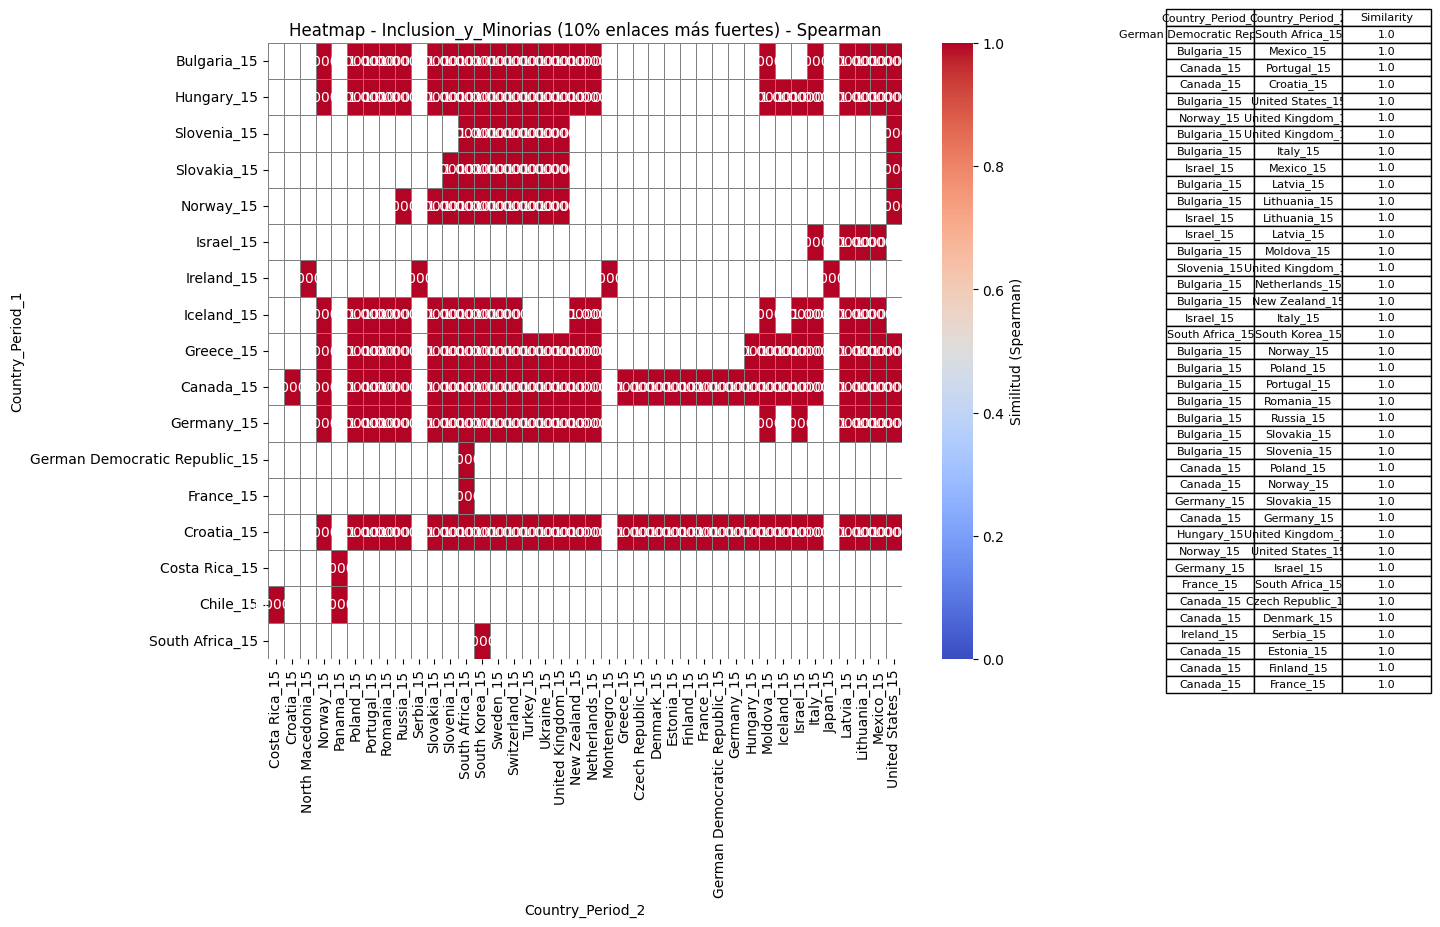

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


Se identificaron 5 clusters para el aspecto 'Inclusion_y_Minorias'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:81: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


Análisis para distancia Euclideana en Inclusion_y_Minorias


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


Se identificaron 5 clusters para el aspecto 'Inclusion_y_Minorias'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:81: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


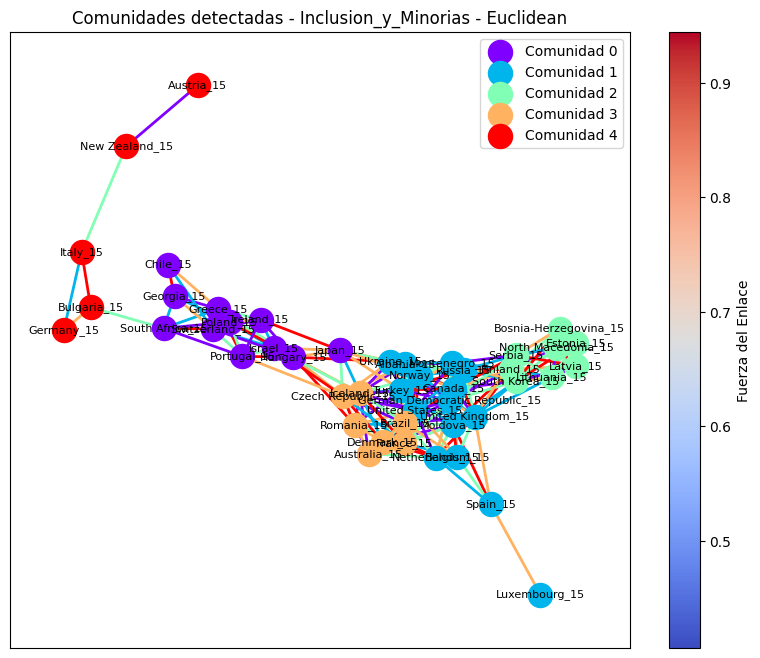


=== Análisis para el aspecto: Orden_y_Corrupcion ===

Spearman correlation between Albania_15 and Australia_15: 1.0
Data 1: per605_1    0.00000
per605_2    0.00000
per304      0.27613
Name: 0, dtype: float64
Data 2: per605_1    0.000000
per605_2    0.000000
per304      0.156477
Name: 24, dtype: float64
Spearman correlation between Albania_15 and Austria_15: 1.0
Data 1: per605_1    0.00000
per605_2    0.00000
per304      0.27613
Name: 0, dtype: float64
Data 2: per605_1    0.000000
per605_2    0.000000
per304      7.969845
Name: 40, dtype: float64
Spearman correlation between Albania_15 and Belgium_15: 1.0
Data 1: per605_1    0.00000
per605_2    0.00000
per304      0.27613
Name: 0, dtype: float64
Data 2: per605_1    0.000000
per605_2    0.000000
per304      2.545142
Name: 58, dtype: float64
Spearman correlation between Albania_15 and Bosnia-Herzegovina_15: 1.0
Data 1: per605_1    0.00000
per605_2    0.00000
per304      0.27613
Name: 0, dtype: float64
Data 2: per605_1    0.00000
per605_2

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)


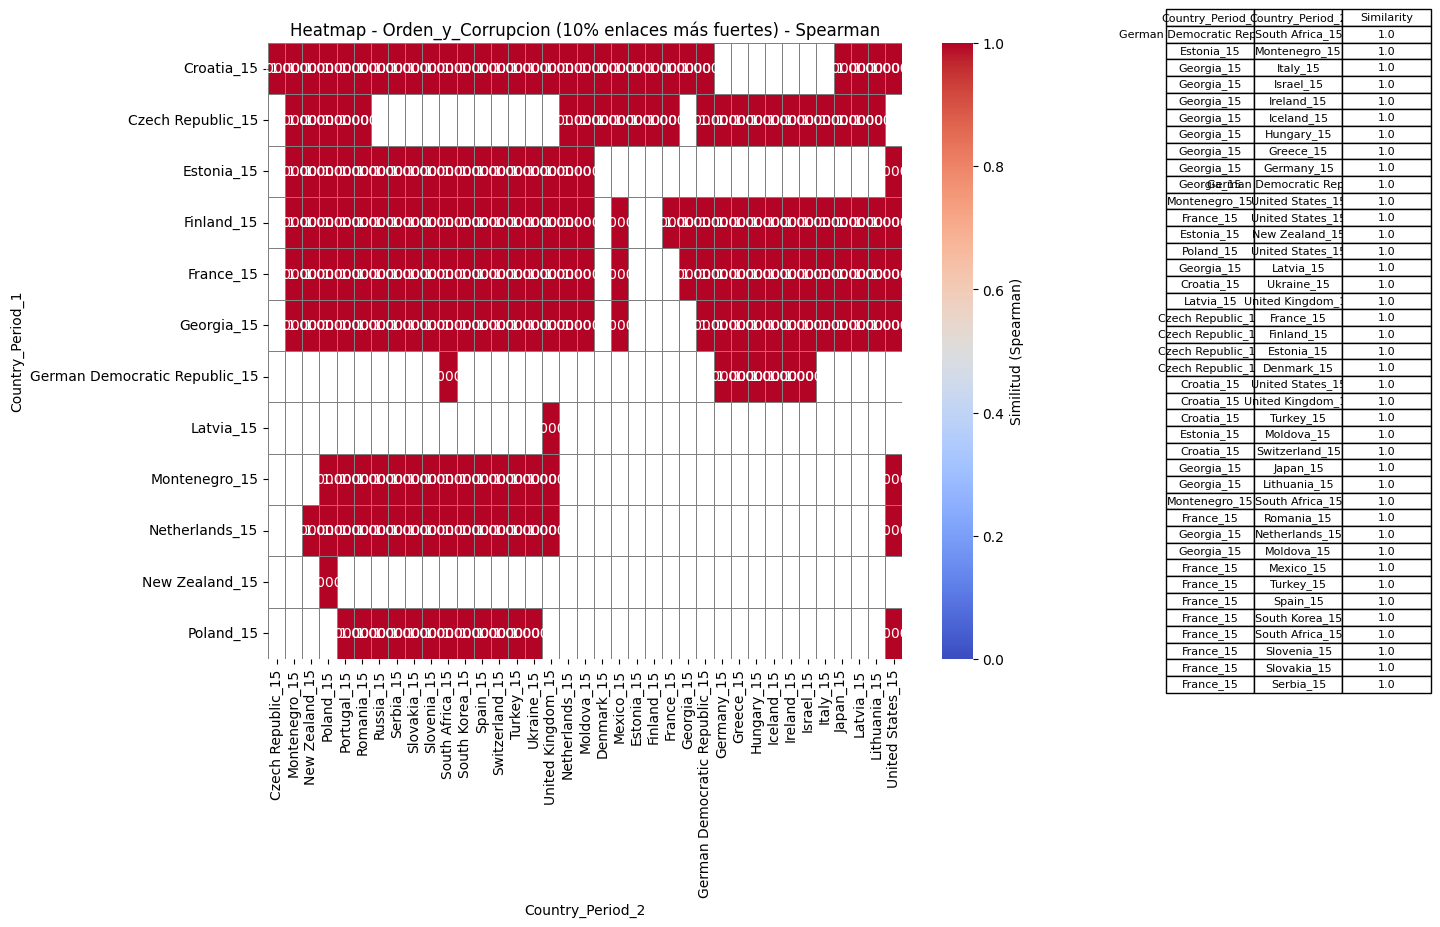

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


Se identificaron 2 clusters para el aspecto 'Orden_y_Corrupcion'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:81: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


Análisis para distancia Euclideana en Orden_y_Corrupcion


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)


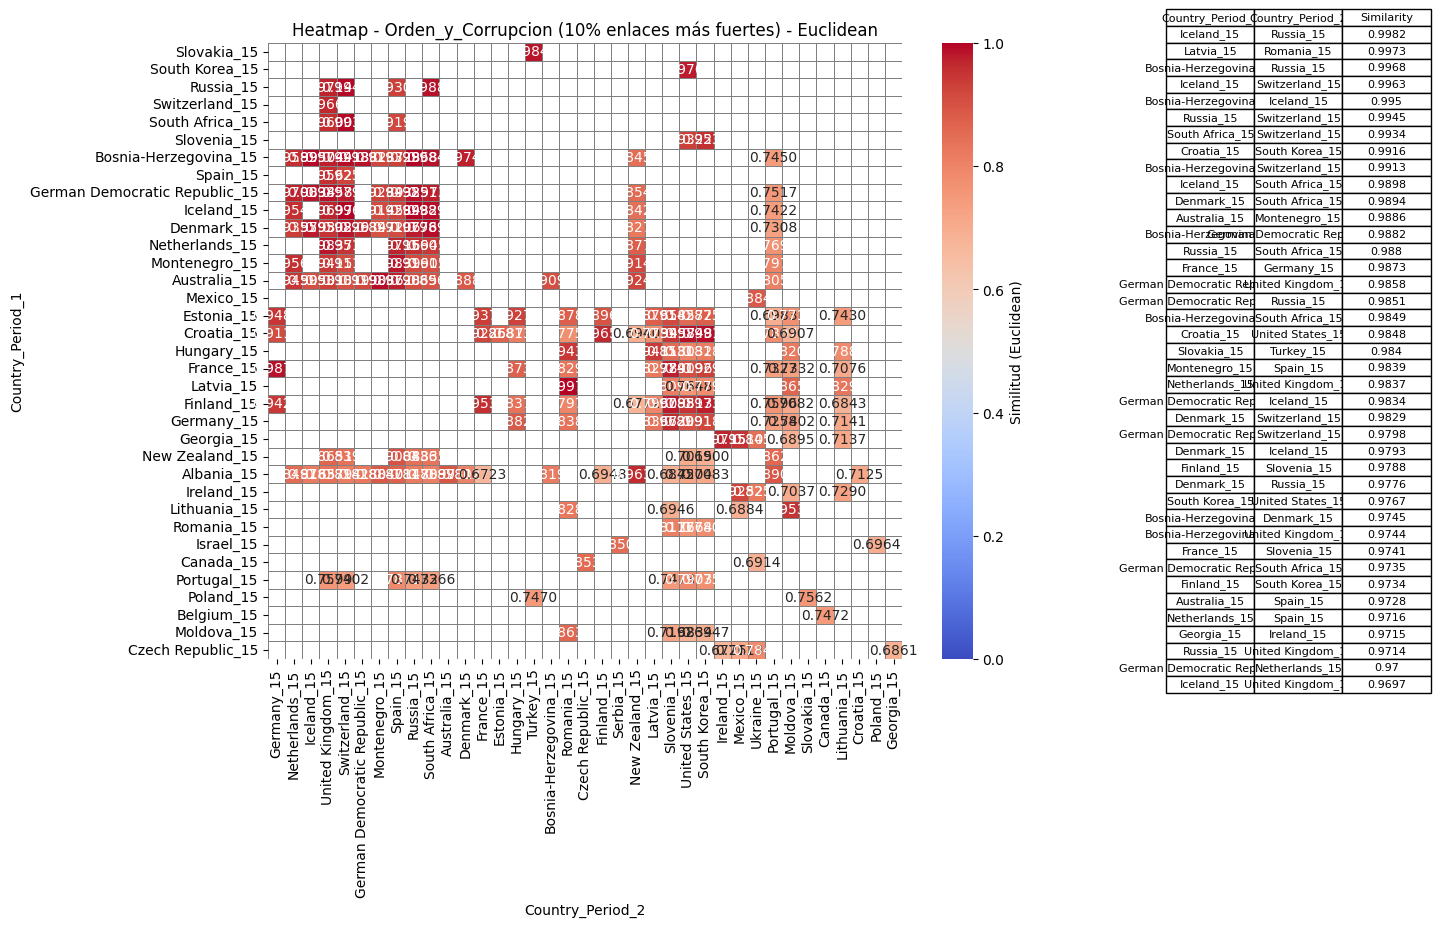

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


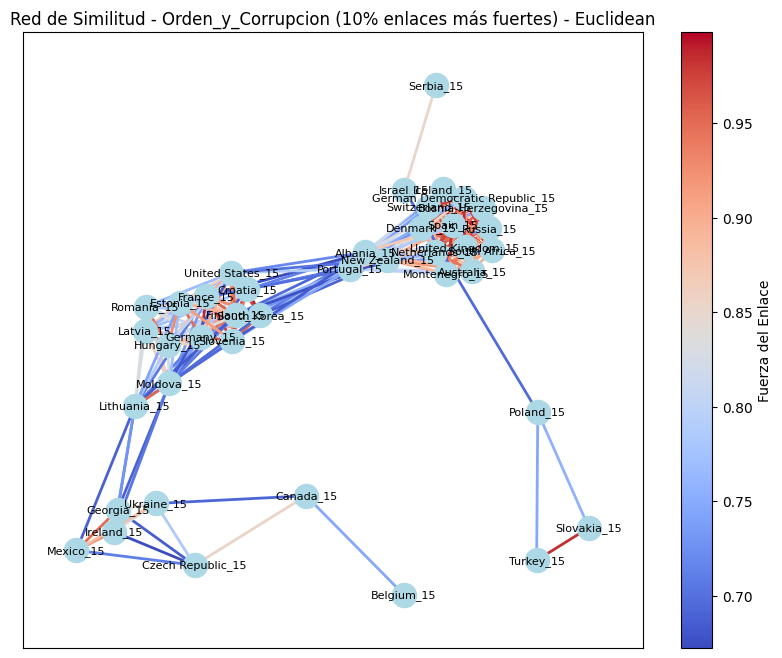

Se identificaron 4 clusters para el aspecto 'Orden_y_Corrupcion'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:81: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


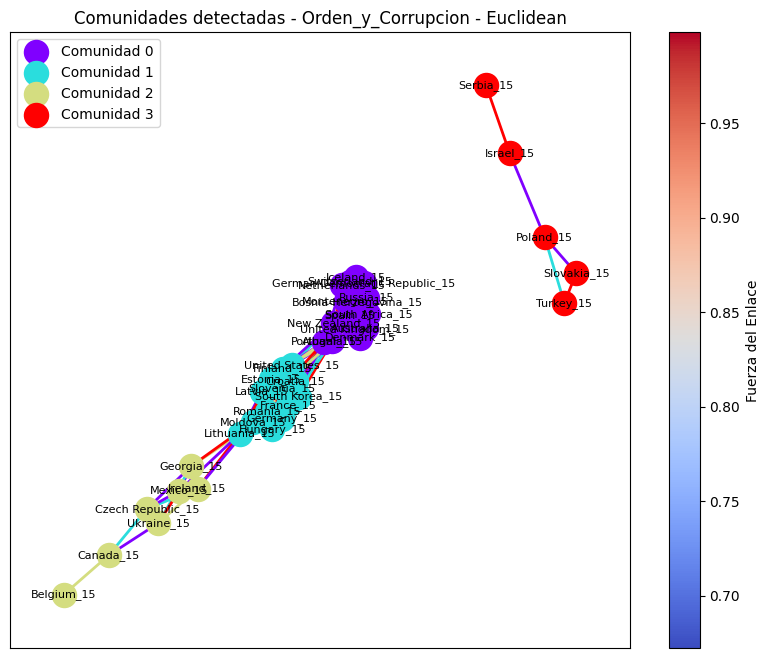


=== Análisis para el aspecto: Medio_Ambiente_y_Sostenibilidad ===

Spearman correlation between Albania_15 and Australia_15: 0.9999999999999999
Data 1: per501      3.545336
per416_2    0.000000
Name: 0, dtype: float64
Data 2: per501      8.125363
per416_2    0.000000
Name: 24, dtype: float64
Spearman correlation between Albania_15 and Austria_15: 0.9999999999999999
Data 1: per501      3.545336
per416_2    0.000000
Name: 0, dtype: float64
Data 2: per501      22.742548
per416_2     0.000000
Name: 40, dtype: float64
Spearman correlation between Albania_15 and Belgium_15: 0.9999999999999999
Data 1: per501      3.545336
per416_2    0.000000
Name: 0, dtype: float64
Data 2: per501      4.601955
per416_2    0.000000
Name: 58, dtype: float64
Spearman correlation between Albania_15 and Bosnia-Herzegovina_15: 0.9999999999999999
Data 1: per501      3.545336
per416_2    0.000000
Name: 0, dtype: float64
Data 2: per501      1.377391
per416_2    0.000000
Name: 66, dtype: float64
Spearman correlation 

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)


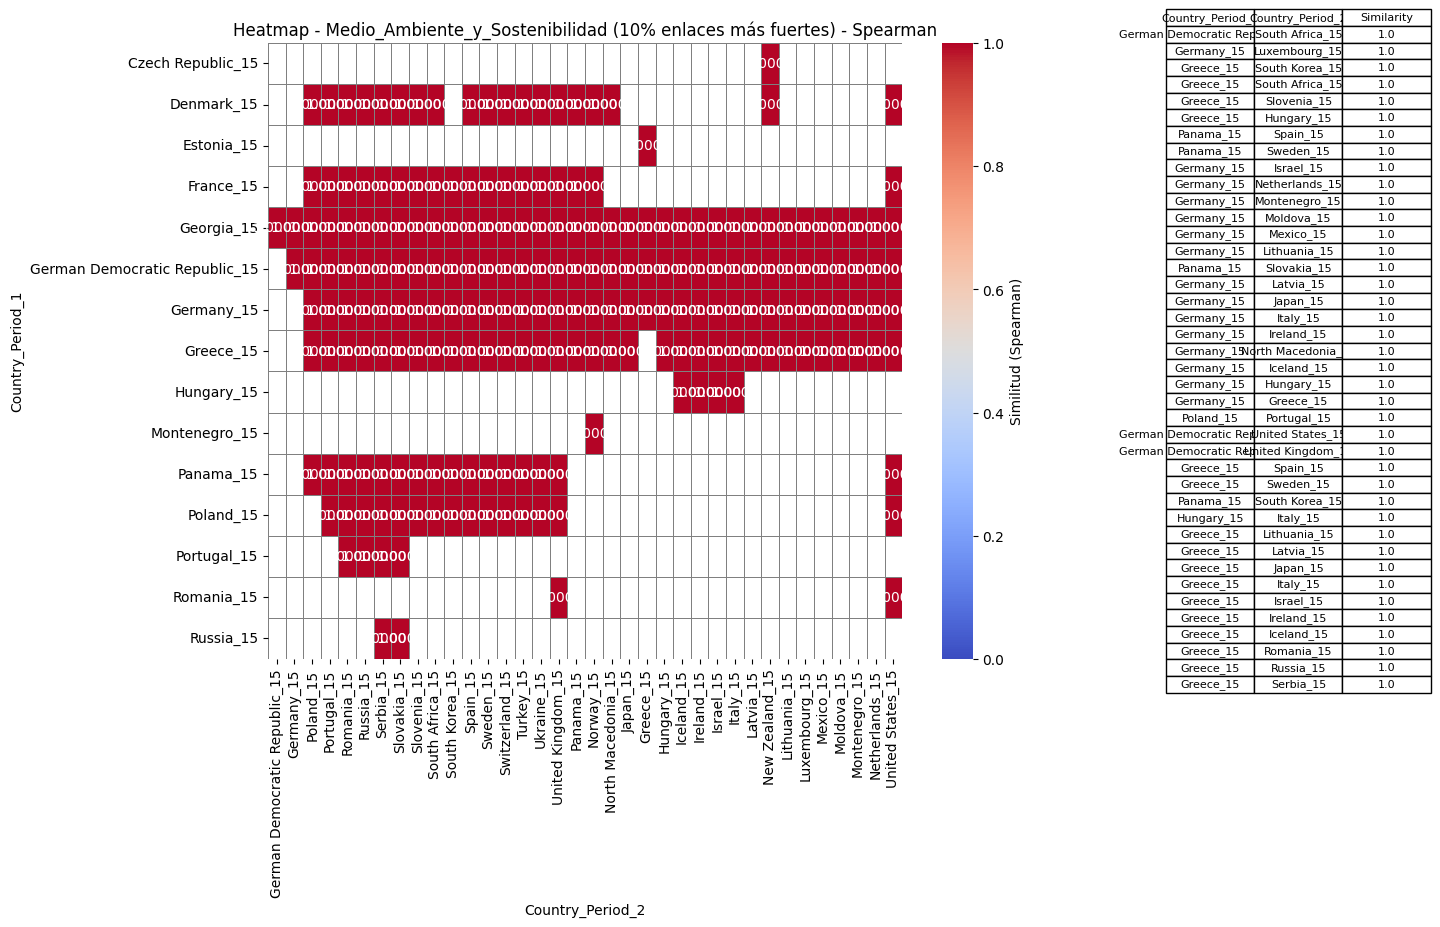

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


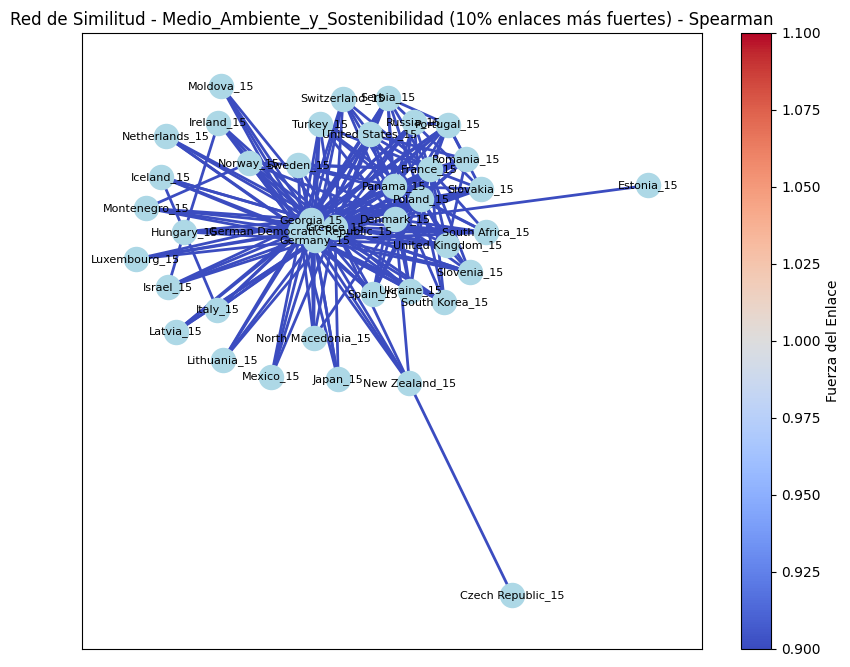

Se identificaron 2 clusters para el aspecto 'Medio_Ambiente_y_Sostenibilidad'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:81: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


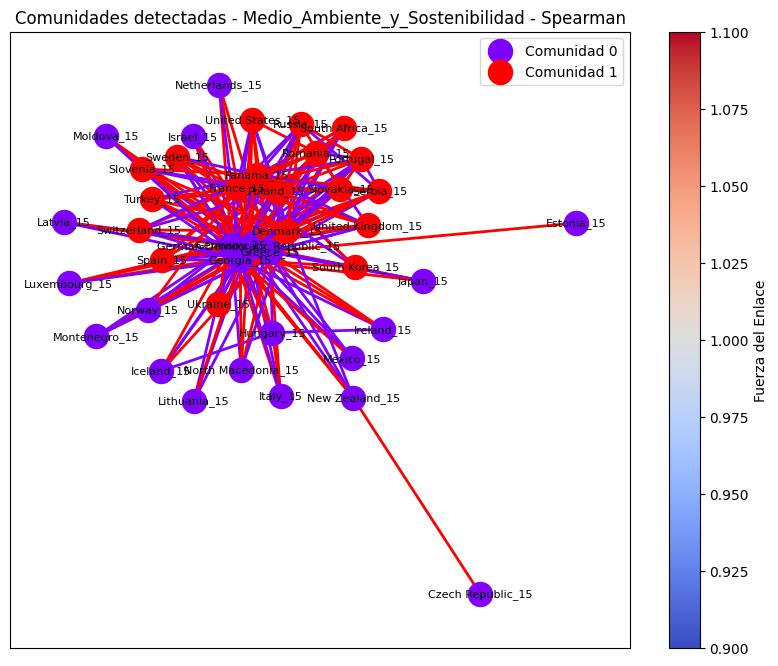

Análisis para distancia Euclideana en Medio_Ambiente_y_Sostenibilidad


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)


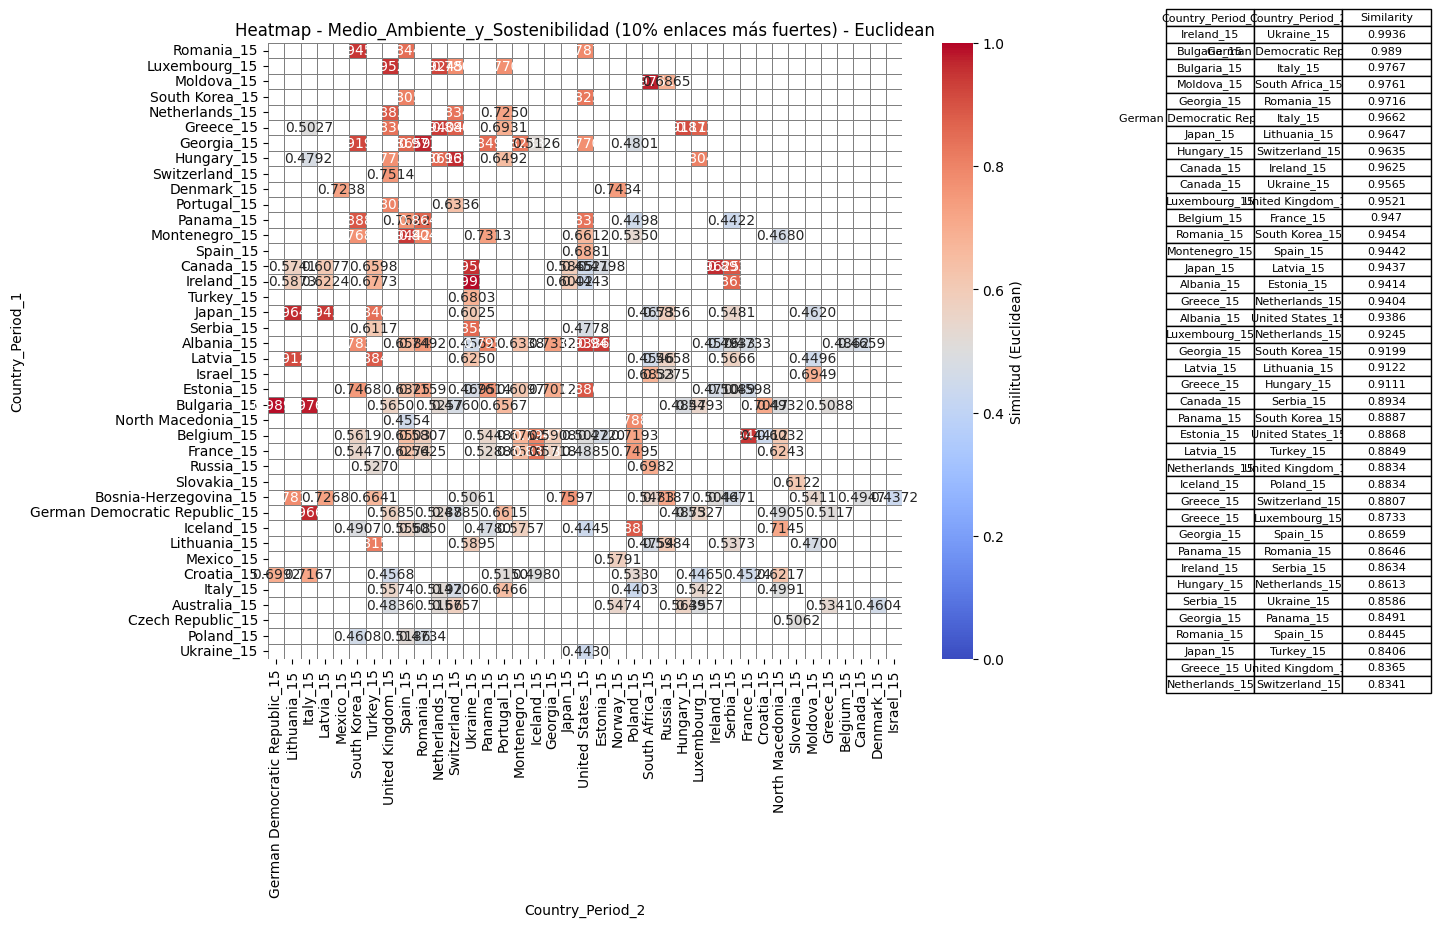

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


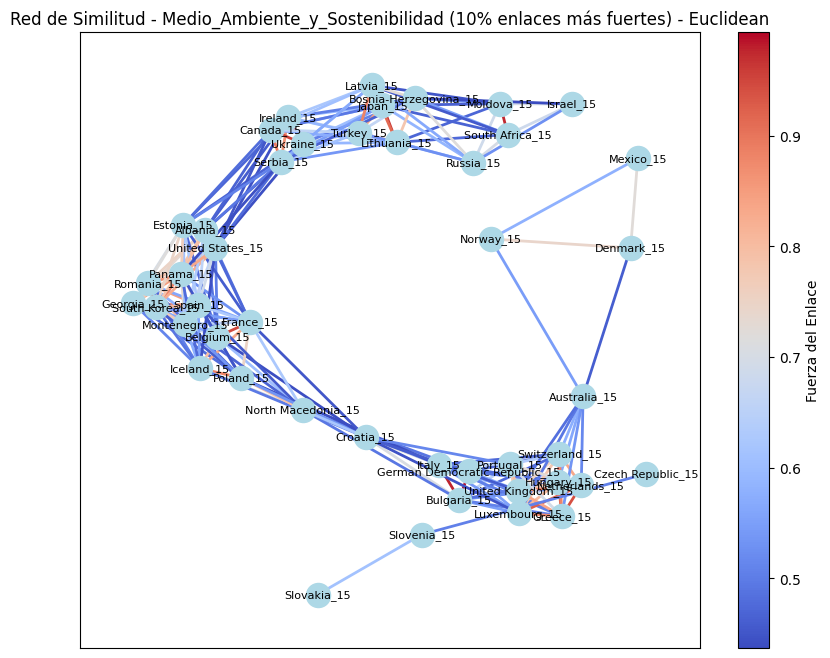

Se identificaron 5 clusters para el aspecto 'Medio_Ambiente_y_Sostenibilidad'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:81: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


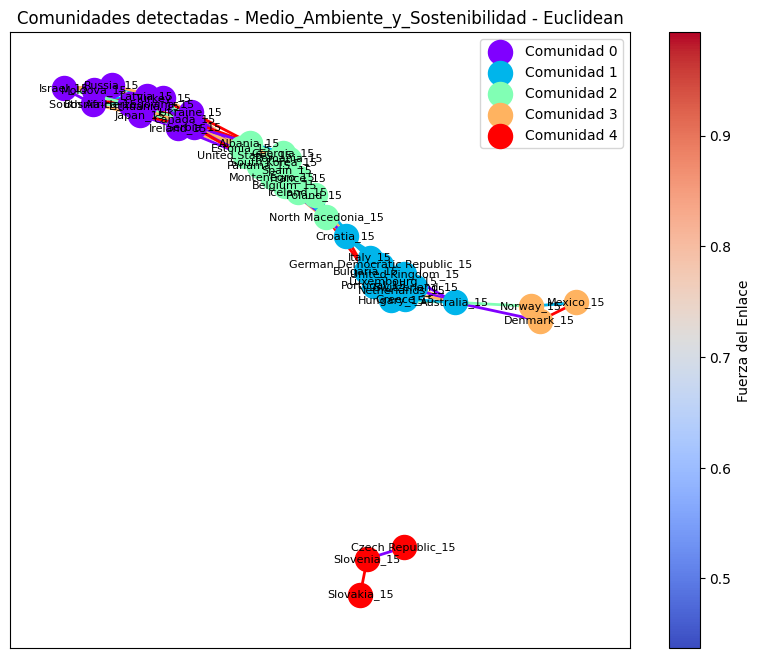


=== Análisis para el aspecto: Pueblos_Originarios ===

Spearman correlation between Brazil_15 and Chile_15: 0.9999999999999999
Data 1: per607_3    0.643182
per608_3    0.000000
Name: 73, dtype: float64
Data 2: per607_3    0.034483
per608_3    0.000000
Name: 102, dtype: float64
Spearman correlation between Brazil_15 and Costa Rica_15: 0.9999999999999999
Data 1: per607_3    0.643182
per608_3    0.000000
Name: 73, dtype: float64
Data 2: per607_3    0.3555
per608_3    0.0000
Name: 113, dtype: float64
Spearman correlation between Brazil_15 and Panama_15: 0.9999999999999999
Data 1: per607_3    0.643182
per608_3    0.000000
Name: 73, dtype: float64
Data 2: per607_3    0.71655
per608_3    0.00000
Name: 432, dtype: float64
Spearman correlation between Chile_15 and Costa Rica_15: 0.9999999999999999
Data 1: per607_3    0.034483
per608_3    0.000000
Name: 102, dtype: float64
Data 2: per607_3    0.3555
per608_3    0.0000
Name: 113, dtype: float64
Spearman correlation between Chile_15 and Panama_15

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)


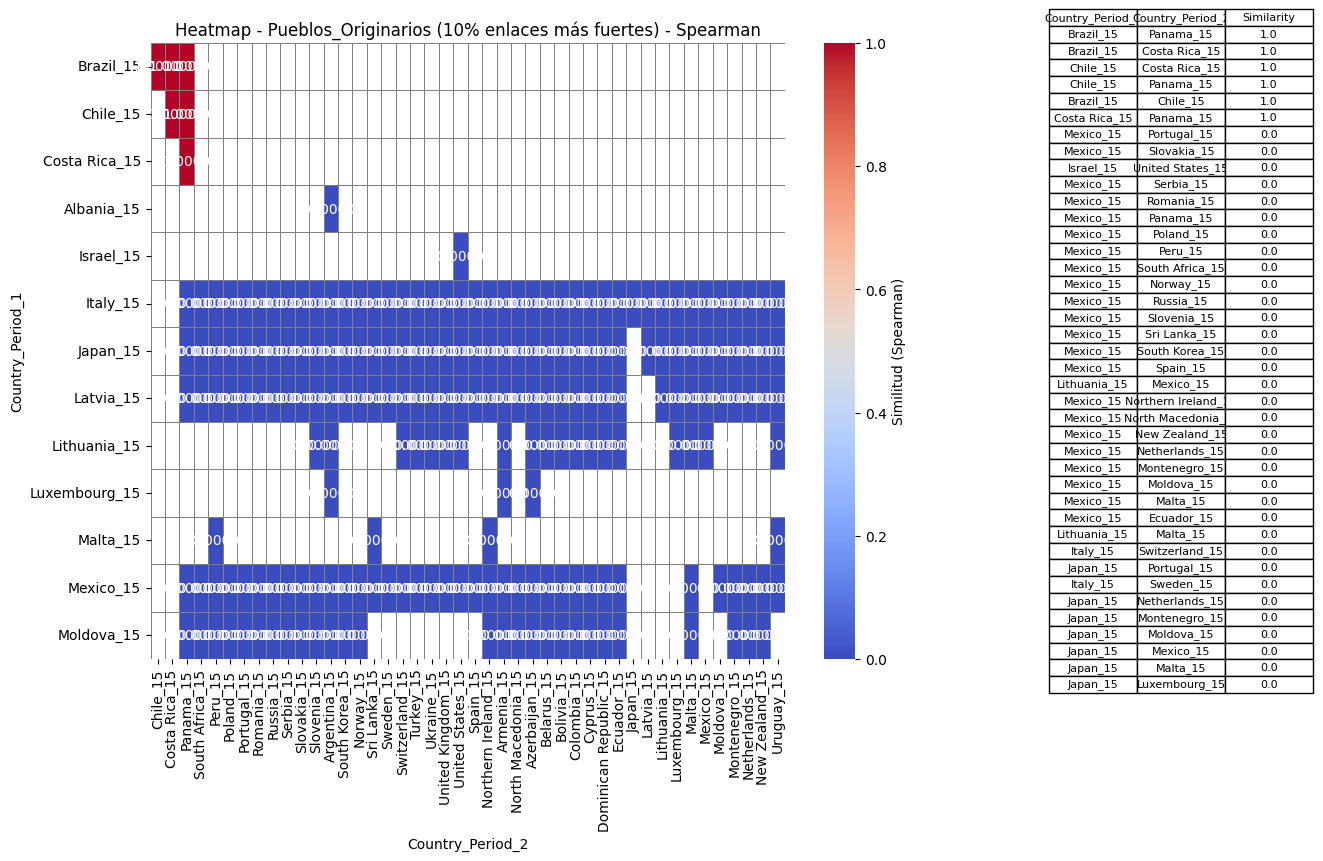

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


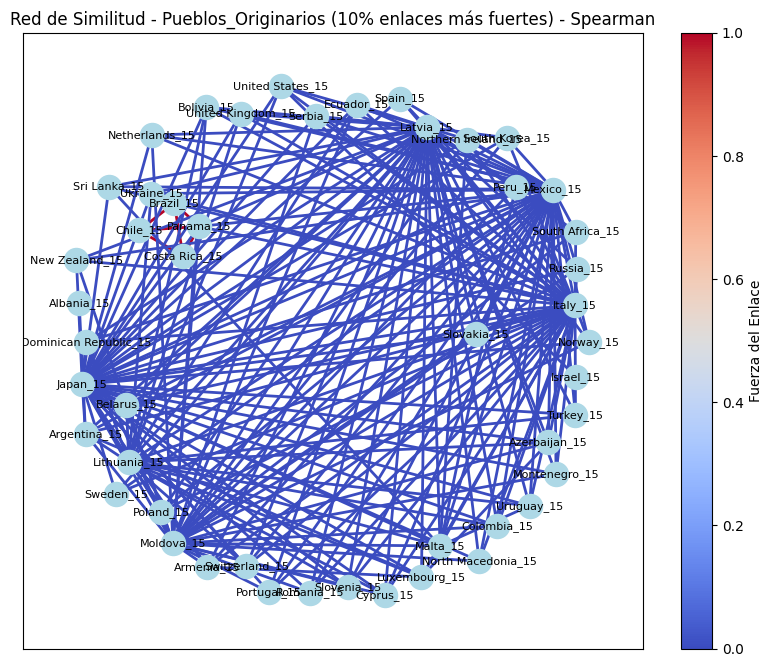

Se identificaron 45 clusters para el aspecto 'Pueblos_Originarios'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:81: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


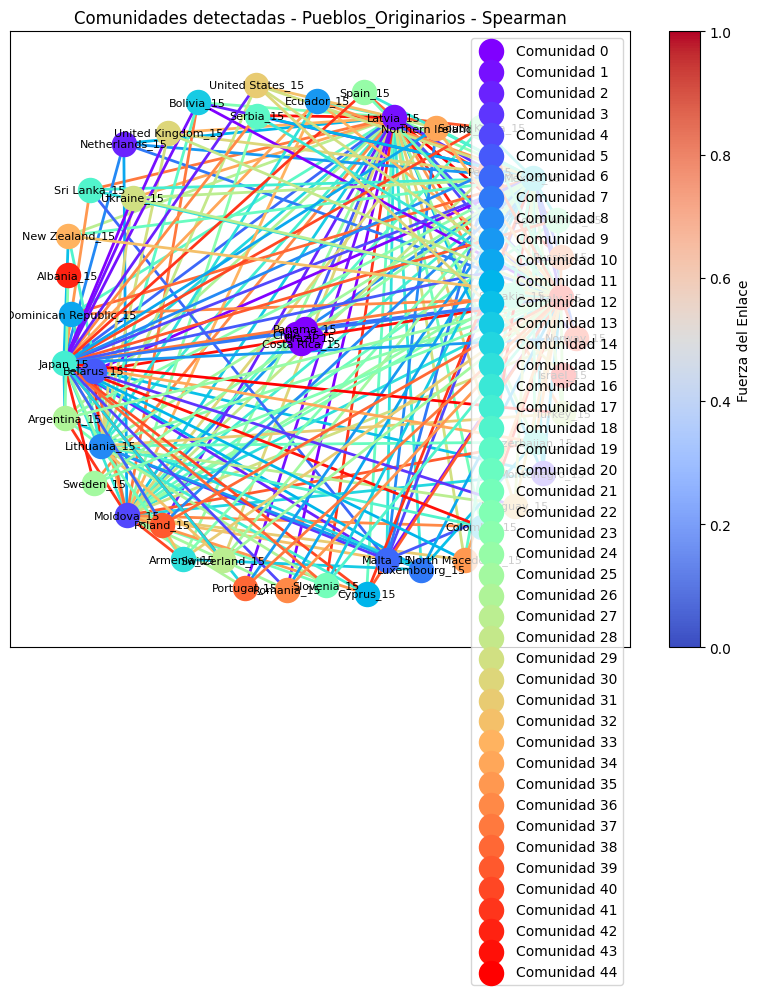

Análisis para distancia Euclideana en Pueblos_Originarios


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)


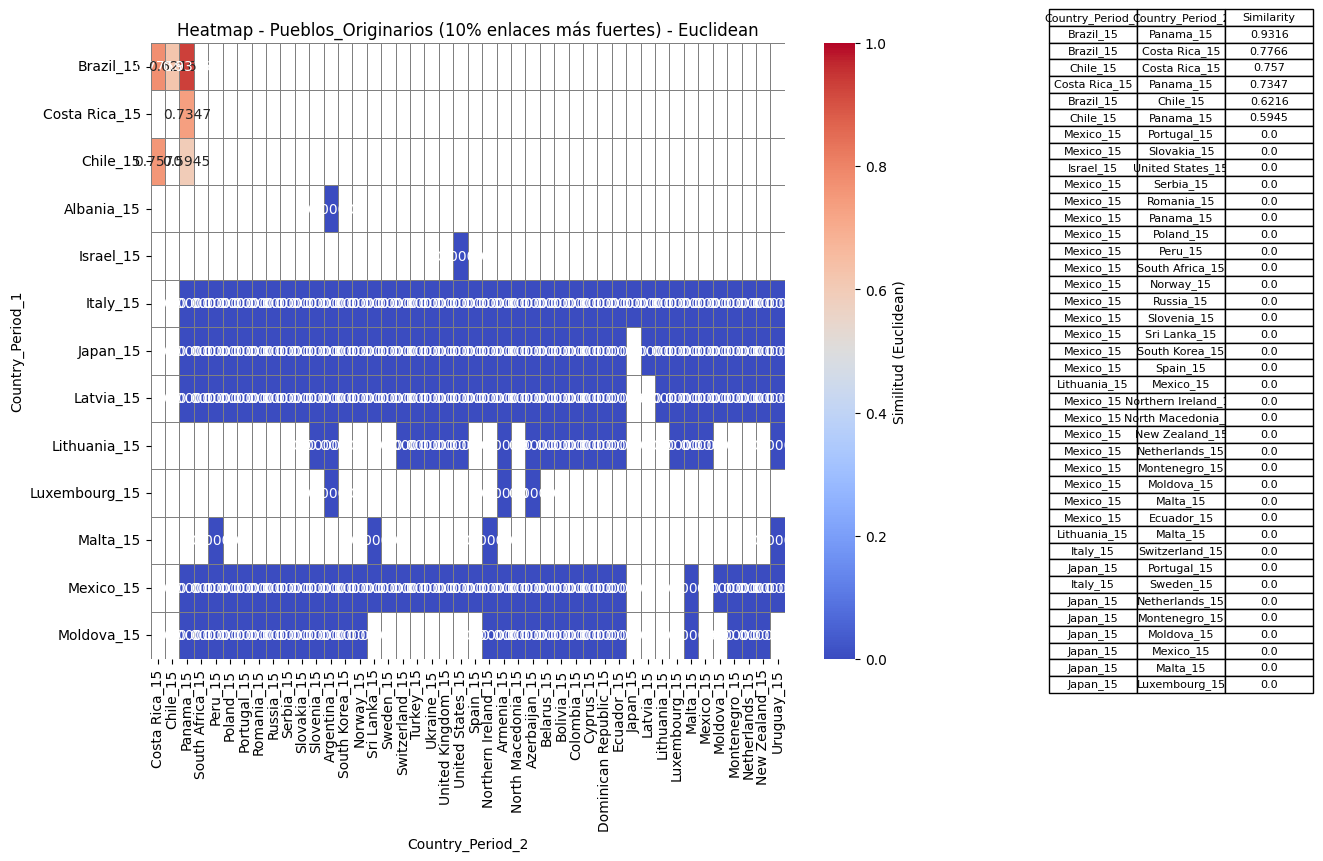

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


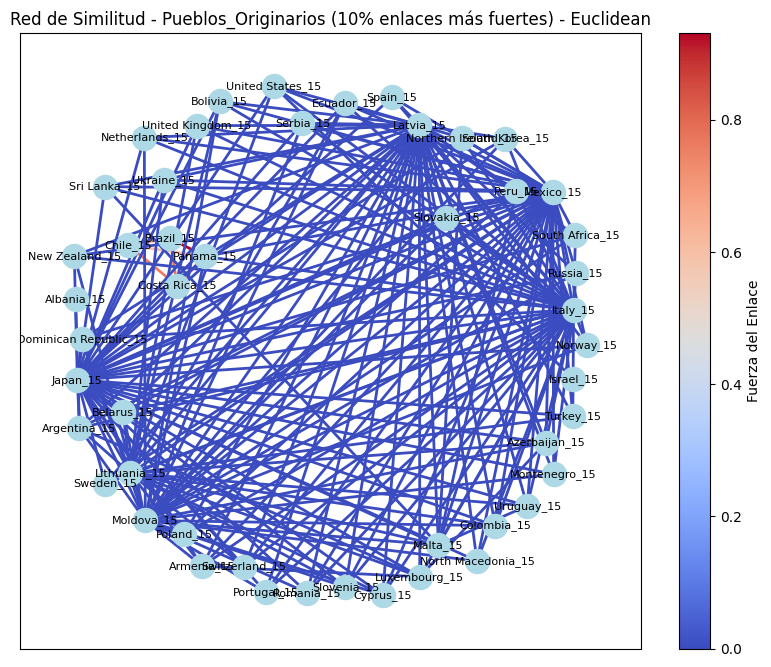

Se identificaron 45 clusters para el aspecto 'Pueblos_Originarios'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_9625/3101508721.py:81: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


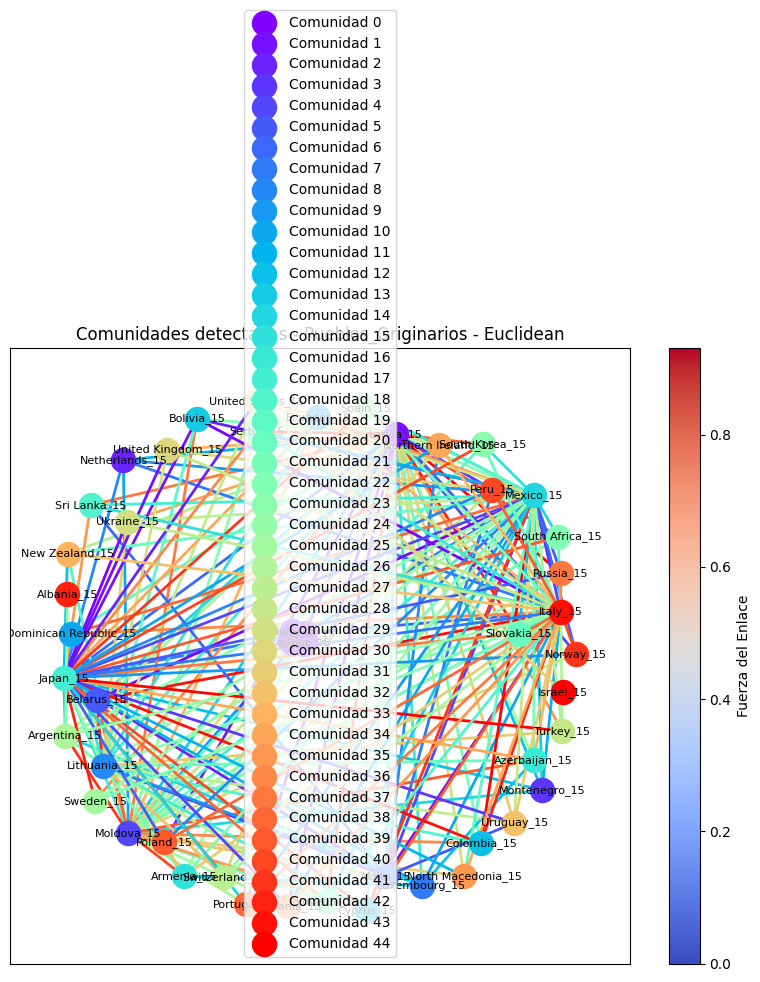

In [40]:
# Ejecución del análisis para calcular similitud y graficar tanto para Spearman como para Euclidean, en todos los aspectos

# Definir el período y el porcentaje de enlaces más fuertes deseado
periodo = 15
porcentaje = 10

# Iterar sobre todos los aspectos en el DataFrame df_aspectos
for aspecto in df_aspectos['aspecto']:
    print(f"\n=== Análisis para el aspecto: {aspecto} ===\n")
    
    # Calcular similitudes usando Spearman
    df_similarity_spearman = calcular_similitudes_todos_paises(df_5_extended, df_aspectos[df_aspectos['aspecto'] == aspecto], porcentaje=100, tipo_similitud='spearman', periodo=periodo)
    print(f"Análisis para correlación de Spearman en {aspecto}")
    generar_red_y_calcular_metricas(df_similarity_spearman, aspecto=aspecto, tipo_similitud='Spearman', porcentaje=porcentaje)
    
    # Calcular similitudes usando Euclidean
    df_similarity_euclidean = calcular_similitudes_todos_paises(df_5_extended, df_aspectos[df_aspectos['aspecto'] == aspecto], porcentaje=100, tipo_similitud='euclidean', periodo=periodo)
    print(f"Análisis para distancia Euclideana en {aspecto}")
    generar_red_y_calcular_metricas(df_similarity_euclidean, aspecto=aspecto, tipo_similitud='Euclidean', porcentaje=porcentaje)

